In [97]:
# 

In [98]:
import sys 
sys.path.append('/home/aistudio/external-libraries/chinese_calendar')
sys.path.append('/home/aistudio/external-libraries/statsmodels')
sys.path.append('/home/aistudio/external-libraries/plotly')
sys.path.append('/home/aistudio/external-libraries/pmdarima')

In [99]:
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import gc

from datetime import date
from datetime import timedelta

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [100]:
# 加载数据
# 仪表能耗
file_name = './work/AI_data/df_meter_daily.pkl'
with open(file_name, 'rb') as f:
    df_meter_daily = pickle.load(f)

# 日期
file_name = './work/AI_data/df_dates.pkl'
with open(file_name, 'rb') as f:
    df_dates = pickle.load(f)

# 每日天气
file_name = './work/AI_data/weather_daily.pkl'
with open(file_name, 'rb') as f:
    weather_daily = pickle.load(f)

# 每小时天气
file_name = './work/AI_data/weather_hour.pkl'
with open(file_name, 'rb') as f:
    weather_hour = pickle.load(f)

# 每日+每小时天气
file_name = './work/AI_data/df_weather_dt.pkl'
with open(file_name, 'rb') as f:
    df_weather_dt = pickle.load(f)

# 每日客流
file_name = './work/AI_data/df_area_custflow.pkl'
with open(file_name, 'rb') as f:
    df_area_custflow = pickle.load(f)

df_meter_daily.shape, df_dates.shape, weather_daily.shape, weather_hour.shape, df_weather_dt.shape,\
df_area_custflow.shape

((625, 243), (88, 243), (301, 243), (7224, 243), (7525, 243), (3416, 243))

In [101]:
meter_index = df_meter_daily.index
df_meter_daily.index = df_meter_daily.index.droplevel(level=[1,2,3,4,5])

In [102]:
meters = list(df_meter_daily.index)

In [103]:
idxs = []
for ids in df_area_custflow.index:
    idxs.append(ids[0] + '_' + str(ids[1]))
df_area_custflow.index = idxs

In [104]:
dates_cols = list(df_dates.index)
weather_dt_cols = list(df_weather_dt.index)
custflow_cols = list(df_area_custflow.index)

In [105]:
df_meter_daily = df_meter_daily.T
df_dates = df_dates.T
df_weather_dt = df_weather_dt.T
df_area_custflow = df_area_custflow.T

In [106]:
# df_meter_daily

In [107]:
original_data = df_meter_daily.join(df_dates, how='left').join(df_weather_dt, how='left').join(df_area_custflow, how='left')

In [108]:
# original_data

In [109]:
# ARIMA模型评价
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    # rmse = np.mean((forecast - actual)**2)**0.5    # RMSE
    rmse_1 = np.sqrt(sum((forecast - actual) ** 2) / actual.size)
    corr = np.corrcoef(forecast, actual)[0, 1]
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    return ({'mape': mape,
             'me': me,
             'mae': mae,
             'mpe': mpe,
             'rmse': rmse_1,
             'corr': corr,
             'minmax': minmax
             })

#### XGBOOST 模型

In [110]:
import xgboost as xgb

In [111]:
XGBOOSTmodels = dict()
df_preds_7days = pd.DataFrame()
start_day = max(df_meter_daily.index) + timedelta(1)
cnt = 0

for ids in meters[0:1]:
    cols_to_transform = dates_cols + weather_dt_cols + custflow_cols 
    train_data = original_data[[ids] + cols_to_transform]
    # train_data.rename(columns={ids: 'y'}, inplace=True)

    scaler_X = StandardScaler()
    train_data[cols_to_transform] = scaler_X.fit_transform(train_data[cols_to_transform])
    scaler_y = StandardScaler()
    train_data[ids] = scaler_y.fit_transform(train_data[[ids]])

    # for i in range(7):
    #     train_data['lag' + str(i+1)] = train_data[ids].shift(i+1)
    
    train_data.dropna(inplace=True)
    train_data['y'] = train_data[ids].shift(-7)

    # 切分数据
    X_test = train_data.loc[pd.date_range('2022-03-25', periods=7, freq='D')].drop('y', axis=1)
    train_data.dropna(inplace=True)
    test_size = 0.15
    test_index = int(len(train_data)*(1-test_size))
    X_train = train_data.drop('y', axis=1).iloc[:test_index]
    y_train = train_data['y'].iloc[:test_index]
    X_eval = train_data.drop('y', axis = 1).iloc[test_index:]
    y_eval = train_data['y'].iloc[test_index:]

    # 创建模型
    model_xgb = xgb.XGBRegressor(max_depth=6, learning_rate=0.01, n_estimators=2000, 
                                objective='reg:squarederror', tree_method='gpu_hist', 
                                # num_class=4,
                                # subsample=0.8, colsample_bytree=0.8, 
                                # min_child_samples=3, 
                                eval_metric=['rmse'], reg_lambda=0.5,
                                seed=2022)

    model_xgb = model_xgb.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=True)

    pred = []
    for i in range(len(X_test)):
        pred.append(model_xgb.predict(X_test.iloc[[i]])[0])
    pred = scaler_y.inverse_transform(pred).reshape(1, -1)
    pred = pd.DataFrame(pred, index=pd.Index([ids]))

    print(cnt, ':', ids)
    cnt += 1

    XGBOOSTmodels[ids] = model_xgb
    df_preds_7days = df_preds_7days.append(pred)

[0]	validation_0-rmse:1.30663
[1]	validation_0-rmse:1.29941
[2]	validation_0-rmse:1.29281
[3]	validation_0-rmse:1.28544
[4]	validation_0-rmse:1.27859
[5]	validation_0-rmse:1.27178
[6]	validation_0-rmse:1.26427
[7]	validation_0-rmse:1.25770
[8]	validation_0-rmse:1.25048
[9]	validation_0-rmse:1.24403
[10]	validation_0-rmse:1.23693
[11]	validation_0-rmse:1.23052
[12]	validation_0-rmse:1.22366
[13]	validation_0-rmse:1.21755
[14]	validation_0-rmse:1.21132
[15]	validation_0-rmse:1.20464
[16]	validation_0-rmse:1.19832
[17]	validation_0-rmse:1.19184
[18]	validation_0-rmse:1.18611
[19]	validation_0-rmse:1.17981
[20]	validation_0-rmse:1.17409
[21]	validation_0-rmse:1.16858
[22]	validation_0-rmse:1.16305
[23]	validation_0-rmse:1.15703
[24]	validation_0-rmse:1.15195
[25]	validation_0-rmse:1.14635
[26]	validation_0-rmse:1.13997
[27]	validation_0-rmse:1.13427
[28]	validation_0-rmse:1.12779
[29]	validation_0-rmse:1.12332
[30]	validation_0-rmse:1.11708
[31]	validation_0-rmse:1.11138
[32]	validation_0-

In [112]:
df_import = pd.DataFrame(zip(X_train.columns, model_xgb.feature_importances_), columns=['features', 'importance'])
df_import.sort_values(by=['importance'], ascending=False, inplace=True)
df_import.reset_index(drop=True, inplace=True)

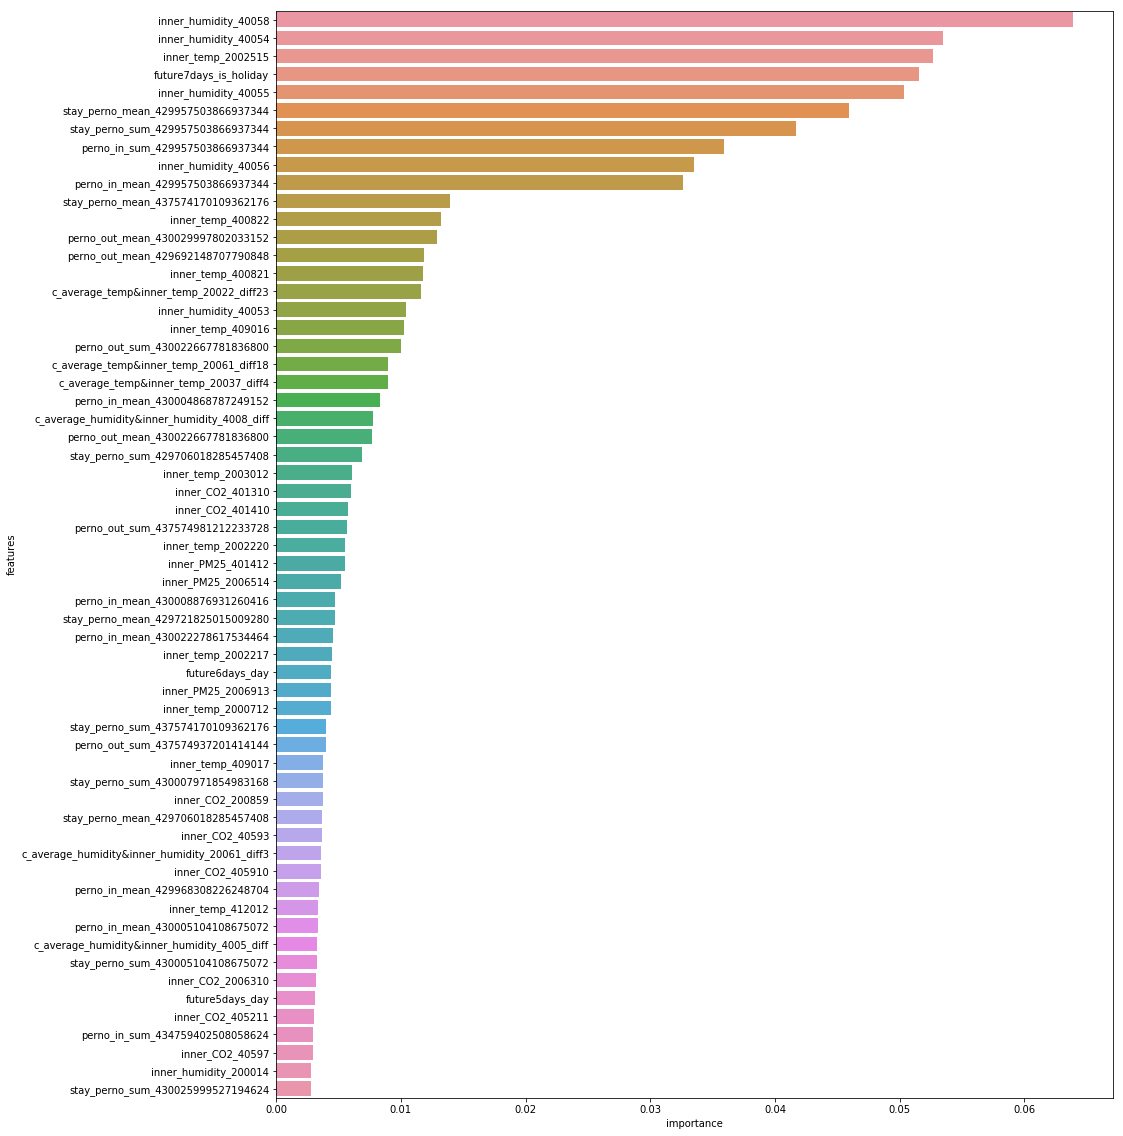

In [113]:
plt.figure(figsize=(15,20))
sns.barplot(x="importance", y="features", data=df_import.iloc[:60])

In [114]:
# df_import[df_import['features'].apply(lambda x: 'lag' in str(x))]

In [115]:
pred_eval = []
for i in range(len(X_eval)):
    pred_eval.append(model_xgb.predict(X_eval.iloc[[i]])[0])
pred_eval = pd.Series(pred_eval, index=y_eval.index)
forecast_accuracy(pred_eval, y_eval)

{'mape': 0.7201855568055249,
 'me': 0.22149977971988744,
 'mae': 0.5237550176796267,
 'mpe': -0.0254744451344876,
 'rmse': 0.7174647333382178,
 'corr': 0.6581493331051702,
 'minmax': -0.39786841184117305}

In [8]:
# with open("./work/arimamodels.pkl", "wb") as f:
#     pickle.dump(arimamodels, file=f)

# with open("./work/preds_7days.pkl", "wb") as f:
#     pickle.dump(preds_7days, file=f)

### 组装输出数据

In [25]:
df_items = pd.DataFrame(zip(*meter_index), index=meter_index.names)
df_items = df_items.T.set_index('meter')

In [26]:
df_preds = df_preds.join(df_items, how='left')
df_preds

,0,1,2,3,4,5,6,meter_name,meter_function_explain,energy_item_id,c_name,c_order
10835,2038.843302,2314.227874,2288.808720,2055.938306,2073.280000,2042.549738,2044.988154,3D1/4 租户负荷1（L1-L2）,正向有功电能二次侧,EI5201314064,租户负荷,68
10836,1809.340631,1880.461826,1873.988667,1737.044231,1725.063006,1729.495210,1772.165050,3D1/5 租户负荷2（B1）,正向有功电能二次侧,EI5201314064,租户负荷,68
10837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3D1/6-1 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119
10838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3D1/6-2 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119
10839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3D1/6-3 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119
...,...,...,...,...,...,...,...,...,...,...,...,...
11568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10D2/8-5 擦窗机（备用）,正向有功电能二次侧,EI5201314075,擦窗机（办公）,45
11575,36.119870,36.043797,36.119044,36.074451,36.107893,36.046209,36.059738,10D2/8-4 弱电间,正向有功电能二次侧,EI5201314023,信息机房（办公）,34
11576,0.012627,0.014455,0.012750,0.012776,0.012874,0.012936,0.012997,10D1/10-1 消防水泵（备）,正向有功电能二次侧,EI5201314027,消防水泵（办公）,37
11581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6D2/6-6 ZBAL,正向有功电能二次侧,EI5201314085,超市,124


In [27]:
df_preds = df_preds.groupby(by=['energy_item_id'])[0, 1, 2, 3, 4, 5, 6].agg('sum').reset_index()
df_preds

,energy_item_id,0,1,2,3,4,5,6
0,EI10101010104001,919.031027,919.031027,919.031027,919.031027,919.031027,919.031027,919.031027
1,EI10101010105001,30.047571,32.980492,35.050766,36.512119,37.543652,38.271784,38.785754
2,EI10101010106001,60.529053,60.557552,60.584546,60.606194,60.624397,60.639490,60.652056
3,EI10101010107001,51.928436,49.989098,49.106890,48.874606,48.679094,48.471338,49.495578
4,EI10101010109001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
73,EI5201314079,173.074282,173.074282,173.074282,173.074282,173.074282,173.074282,173.074282
74,EI5201314080,58.448406,57.671723,66.682093,65.853257,62.736660,63.446885,63.659362
75,EI5201314081,3535.957823,3597.382328,3597.225100,3548.091307,3546.765473,3545.564873,3551.103653
76,EI5201314082,280.750806,281.119171,281.289036,281.341795,281.733215,281.539829,281.685388


In [28]:
df_submission = pd.read_excel('../data/1.3 t_research_energyitem.xlsx')
df_submission = df_submission[['c_order', 'c_logic_id', 'c_name', 'c_parent']]

In [29]:
def get_energyitem_level(item):
    if len(df_submission[df_submission['c_logic_id'] == item]) == 0:
        return 0
    else:
        p_item = df_submission[df_submission['c_logic_id'] == item]['c_parent'].values[0]
#         print(item, p_item)
        return 1 + get_energyitem_level(p_item)

In [30]:
def is_leaf(item):
    if len(df_submission[df_submission['c_parent'] == item]) == 0:
        return True
    else:
        return False

In [31]:
df_submission['level'] = df_submission['c_logic_id'].apply(lambda x: get_energyitem_level(x))
df_submission['is_leaf'] = df_submission['c_logic_id'].apply(lambda x: is_leaf(x))

In [32]:
df_submission.sort_values(by='c_order', inplace=True)
df_submission

,c_order,c_logic_id,c_name,c_parent,level,is_leaf
61,0,EI1001,总能耗,-1,1,False
70,1,EI101001,光环中心A座,EI1001,2,False
77,2,EI101030102001,办公公区（办公）,EI101001,3,False
103,3,EI101030409001,强弱电机房（办公）,EI101030102001,4,False
84,4,EI101030410001,信息机房（办公）,EI101030409001,5,True
...,...,...,...,...,...,...
52,120,EI101020601001,物业用电,EI10102001,4,True
100,121,EI101020602001,活动用电,EI10102001,4,True
46,122,EI5201314007,运动秀场,EI10102001,4,True
51,123,EI10105001,其他用电,EI10102001,4,True


In [33]:
df_submission = df_submission.merge(df_preds, how='left', left_on=['c_logic_id'], right_on=['energy_item_id'])
df_submission

,c_order,c_logic_id,c_name,c_parent,level,is_leaf,energy_item_id,0,1,2,3,4,5,6
0,0,EI1001,总能耗,-1,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,EI101001,光环中心A座,EI1001,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,EI101030102001,办公公区（办公）,EI101001,3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,EI101030409001,强弱电机房（办公）,EI101030102001,4,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,EI101030410001,信息机房（办公）,EI101030409001,5,True,EI101030410001,247.569369,244.499829,244.960971,246.238349,245.666806,242.284732,246.167311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,120,EI101020601001,物业用电,EI10102001,4,True,EI101020601001,158.215191,121.602842,128.811352,169.786512,171.951730,172.659048,170.384336
121,121,EI101020602001,活动用电,EI10102001,4,True,EI101020602001,11.430595,5.302857,12.596281,6.037975,5.741435,20.703072,7.574846
122,122,EI5201314007,运动秀场,EI10102001,4,True,EI5201314007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
123,123,EI10105001,其他用电,EI10102001,4,True,EI10105001,-0.403393,-0.758443,-1.025198,-1.228939,-1.394443,-1.537924,-1.668964


In [34]:
# 遍历个非叶子科目，统计能耗
for l in range(df_submission['level'].max() - 1, -1, -1):
    for ids in df_submission[(df_submission['level'] == l) & (df_submission['is_leaf'] == False)].index:
        item = df_submission.iloc[ids]['c_logic_id']
        df_submission.loc[ids, [0,1,2,3,4,5,6]] = df_submission[df_submission['c_parent'] == item][[0,1,2,3,4,5,6]].sum()

In [35]:
df_submission_head = \
pd.concat(\
(pd.DataFrame([['998','998','公共用电','998'],
              ['999','999','商户用电','999']], columns=['c_order', 'c_logic_id', 'c_name', 'c_parent'])
,
(pd.DataFrame(np.concatenate((\
#公共用电=（c_order=2+c_order=31 +c_order=72）
df_submission[df_submission['c_order'] == 2][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_submission[df_submission['c_order'] == 31][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_submission[df_submission['c_order'] == 72][[0, 1, 2, 3, 4, 5, 6]].values\
,
# 商户用电=（c_order=29+c_order=58 +c_order=60 +c_order=124）
df_submission[df_submission['c_order'] == 29][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_submission[df_submission['c_order'] == 58][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_submission[df_submission['c_order'] == 60][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_submission[df_submission['c_order'] == 124][[0, 1, 2, 3, 4, 5, 6]].values\
)))))
, axis=1)

In [36]:
df_submission = pd.concat((df_submission_head, df_submission), axis=0)

In [37]:
df_submission[['c_order', 'c_logic_id', 'c_name', 'c_parent', 0, 1, 2, 3, 4, 5, 6]].to_csv("./submission/submission_SARIMAX.csv", index=None)